In [30]:
import numpy as np
import pandas as pd
import torch
import torchvision as tv
import re
import time
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module, GRU, Embedding, Linear, Sigmoid, CrossEntropyLoss, ReLU, Tanh, Sequential
from torch import nn
from torchvision import transforms
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [31]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [33]:
fmnist = datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
data_loader = DataLoader(fmnist, batch_size=batch_size, shuffle=True)

In [34]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = Sequential(
            Linear(self.n_input, 1024),
            ReLU(),
            Linear(1024, 512),
            ReLU(),
            Linear(512, 10)
        )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.main(x)
        return nn.functional.log_softmax(x, dim=1)
        

In [35]:
discriminator = Discriminator().to(device)

In [36]:
optim_d = optim.Adam(discriminator.parameters(), lr=0.00005)

In [37]:
criterion = nn.CrossEntropyLoss()

In [38]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [39]:
# function to train the discriminator network
def train_discriminator(optimizer, data, labels):
    optimizer.zero_grad()
    output = discriminator(data)
    # print(output.shape)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    return loss, output

In [40]:
losses = []
accuracies = []
epochs = 50

for epoch in range(epochs):
    total = 0
    acc_loss = 0
    correct = 0
    for bi, (images, labels) in enumerate(data_loader):
        loss, output = train_discriminator(optim_d, images, labels)
        acc_loss += loss
        b_size = len(labels)
        total += b_size
        predicted = torch.argmax(output, dim=1)
        correct += (predicted==labels).sum()
        accuracy = correct/total
        avg_loss = loss/b_size
        if bi%20==0:
            print(f"Epoch {epoch}/{epochs}; Batch {bi}: Loss = {loss:.5f}\t\tAccuracy = {accuracy:.5f}")

    
    losses.append(acc_loss/total)
    accuracies.append(accuracy)


Epoch 0/50; Batch 0: Loss = 2.31481		Accuracy = 0.11523
Epoch 0/50; Batch 20: Loss = 1.76999		Accuracy = 0.54781
Epoch 0/50; Batch 40: Loss = 1.26708		Accuracy = 0.60147
Epoch 0/50; Batch 60: Loss = 0.86295		Accuracy = 0.63742
Epoch 0/50; Batch 80: Loss = 0.77655		Accuracy = 0.66119
Epoch 0/50; Batch 100: Loss = 0.68566		Accuracy = 0.67884
Epoch 1/50; Batch 0: Loss = 0.65234		Accuracy = 0.74805
Epoch 1/50; Batch 20: Loss = 0.61245		Accuracy = 0.78255
Epoch 1/50; Batch 40: Loss = 0.61174		Accuracy = 0.78568
Epoch 1/50; Batch 60: Loss = 0.50427		Accuracy = 0.79137
Epoch 1/50; Batch 80: Loss = 0.48384		Accuracy = 0.79545
Epoch 1/50; Batch 100: Loss = 0.49257		Accuracy = 0.79954
Epoch 2/50; Batch 0: Loss = 0.50415		Accuracy = 0.83203
Epoch 2/50; Batch 20: Loss = 0.48270		Accuracy = 0.82636
Epoch 2/50; Batch 40: Loss = 0.49469		Accuracy = 0.82417
Epoch 2/50; Batch 60: Loss = 0.53742		Accuracy = 0.82294
Epoch 2/50; Batch 80: Loss = 0.47925		Accuracy = 0.82591
Epoch 2/50; Batch 100: Loss = 0.

In [53]:
losses0 = [i.detach() for i in losses]

No handles with labels found to put in legend.


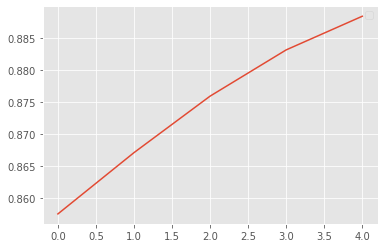

In [57]:
plt.figure()
plt.plot(losses0)
plt.plot(accuracies)
plt.legend()
plt.savefig(path + 'loss_and_accuracy.png')